## Stationary data analysis - Simulated Data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/REPO_HR++/GATE_HR/GeneralScripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({ # Makes the plots look nice
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

Below function is to read in the raw LORs.  

In [4]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [12]:
pathToLors = "/home/rayhaan/REPO_HR++/GATE_HR/NPYOutput/RandomWalk_Lambda_1.00mm_Tau_1.00ms_1mCi_1s_NRW-100_68Ga.npy"
pathToTrueData = "/home/rayhaan/REPO_HR++/GATE_HR/data/RW4_TS_1.00ms_SS_1.00mm.placements"
lors = loadData(path = pathToLors)
truePath = loadTruePath(path = pathToTrueData)

# Interpolation algorithm.  Paper that we worked on.  Improves spatiotemporal resolution.  
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

This is now what the LORs look like.  

In [8]:
print(lors_2)

pept.LineData (samples: 1)
--------------------------
sample_size = 297915
overlap = 0
lines = 
  (rows: 297915, columns: 7)
  [[ 0.00000000e+00 -3.24727264e+02 ...  2.82083923e+02  1.71410007e+01]
   [ 3.03030303e-06  4.03134918e+01 ...  4.29491302e+02  1.71410007e+01]
   ...
   [ 1.99498394e+00 -1.84405960e+02 ...  3.82456146e+02 -8.08550034e+01]
   [ 1.99900000e+00  3.39754913e+02 ...  4.13521606e+02 -5.14230003e+01]]
columns = ['t', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
attrs = {}



Now lets perform some optimsiation since we know the location.  We want to optimise the tracking parameters.  

The first function is the error fucntion which will be minimised and the second function actually performs the minimisation of uncertainty by trying to find the optimal tracking parameters for PEPT-ML

In [10]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError


def optAllML(lowerLocRate, upperLocRate, Data, truePath, totalTime):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 1.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True, max_workers = 100)

        locRate = len(locs.points)/totalTime

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    # The optimisation space!
    space = [Integer(250, 300, name = 'SS1'),
            # Real(1.0, 3.0, name = 'MD'),
            Real(0.1, 0.6, name = 'TF1'),
            Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 10, verbose = True, random_state = 254654)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [13]:
optimalParameters = optAllML(lowerLocRate = 900, upperLocRate = 1100, Data = lors_2, truePath = truePath, totalTime = 1.0)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1079/1079 [00:01<00:00, 1007.48it/s]



Processed samples in 8.240180015563965 s

The error is: 10000.509079384825 mm, the location rate is: 103.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.2451
Function value obtained: 10000.5091
Current minimum: 10000.5091
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1126/1126 [00:01<00:00, 1046.65it/s]



Processed samples in 3.2897262573242188 s

The error is: 0.6577068987550189 mm, the location rate is: 1099.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.2943
Function value obtained: 0.6577
Current minimum: 0.6577
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1111/1111 [00:01<00:00, 1035.84it/s]



Processed samples in 5.981797695159912 s

The error is: 0.6592662831050512 mm, the location rate is: 1081.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.9867
Function value obtained: 0.6593
Current minimum: 0.6577
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1030/1030 [00:01<00:00, 978.82it/s]



Processed samples in 6.755363702774048 s

The error is: 10000.474299333513 mm, the location rate is: 110.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.7629
Function value obtained: 10000.4743
Current minimum: 0.6577
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1135/1135 [00:01<00:00, 1060.46it/s]



Processed samples in 4.90410590171814 s

The error is: 10000.489210632039 mm, the location rate is: 112.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.9112
Function value obtained: 10000.4892
Current minimum: 0.6577
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1091/1091 [00:02<00:00, 511.53it/s]



Processed samples in 5.058368444442749 s

The error is: 0.6723166858657417 mm, the location rate is: 1046.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.0655
Function value obtained: 0.6723
Current minimum: 0.6577
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:01<00:00, 1087.51it/s]



Processed samples in 3.5798463821411133 s

The error is: 10000.643646351458 mm, the location rate is: 1111.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 3.5863
Function value obtained: 10000.6436
Current minimum: 0.6577
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1049/1049 [00:01<00:00, 986.55it/s]



Processed samples in 4.806167125701904 s

The error is: 0.6485091370584782 mm, the location rate is: 1013.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.8113
Function value obtained: 0.6485
Current minimum: 0.6485
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 988/988 [00:00<00:00, 1149.96it/s]



Processed samples in 4.829485893249512 s

The error is: 10000.53227095808 mm, the location rate is: 99.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.8354
Function value obtained: 10000.5323
Current minimum: 0.6485
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1017/1017 [00:02<00:00, 502.71it/s]



Processed samples in 7.002288103103638 s

The error is: 10000.592056957796 mm, the location rate is: 95.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.3517
Function value obtained: 10000.5921
Current minimum: 0.6485


Great!  The tracking parameters are now optimised enough.  Enough in that we have the location rate we're looking for (+- 1.0 kHz) and the tracking parrameters that minimise the error around that location rate.  This was performed with the use of Gaussian processes since a grid based approach would take forever.  

In [14]:
print("The optimal Tracking Parameters are:")
Params = ["SS1", "TF1", "TF1"]
for i in range(len(Params)):
    print("{} = {}".format(Params[i], optimalParameters[i]))

The optimal Tracking Parameters are:
SS1 = 0.6485091370584782
TF1 = 277
TF1 = 0.3379744086916586


Now lets track using these optimal parameters!

In [15]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optimalParameters[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optimalParameters[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optimalParameters[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [16]:
locations = MLPipeOpt.fit(lors_2, max_workers = 100, verbose = True)

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:01<00:00, 953.76it/s]


Processed samples in 17.54656219482422 s



Awesome!  Now we have our locations.  At this point we can do whatever we want with the locations now.  let's visualise the locations

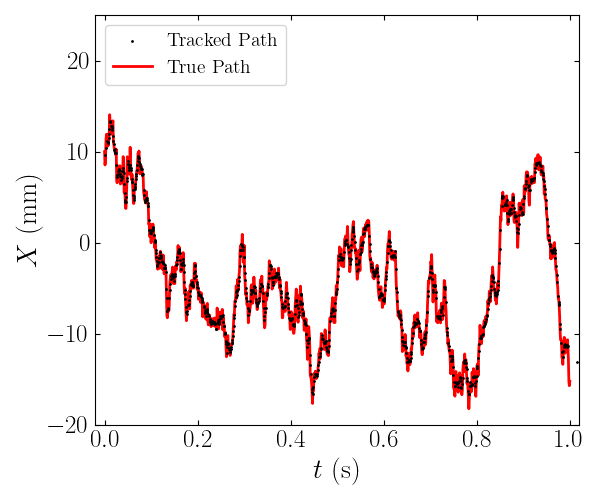

In [33]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize = (6, 5), sharex = "col")

s = 20

ax1.scatter(locations['t'], locations['x'], s = 1, color = 'k', label = "Tracked Path", zorder = 1)
# ax2.scatter(locations['t'], locations['y'], s = 1, color = 'k', label = "Tracked Path", zorder = 1)
# ax3.scatter(locations['t'], locations['z'], s = 1, color = 'k', label = "Tracked Path", zorder = 1)

ax1.plot(truePath['t'], truePath['x'], color = 'r', lw = 2, label = "True Path", zorder = 0 )
# ax2.plot(truePath['t'], truePath['y'], color = 'r', lw = 2, label = "True Path", zorder = 0 )
# ax3.plot(truePath['t'], truePath['z'], color = 'r', lw = 2, label = "True Path", zorder = 0 )

ax1.legend(loc = "upper left", fontsize = s - 6)
# ax2.legend(loc = "upper left", fontsize = s - 6)
# ax3.legend(loc = "upper left", fontsize = s - 6)


ax1.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax1.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)
# ax2.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
# ax2.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)
# ax3.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
# ax3.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax1.tick_params(axis="x", labelsize = s - 2) 
ax1.tick_params(axis="y", labelsize = s - 2)
# ax2.tick_params(axis="x", labelsize = s - 2) 
# ax2.tick_params(axis="y", labelsize = s - 2)
# ax3.tick_params(axis="x", labelsize = s - 2) 
# ax3.tick_params(axis="y", labelsize = s - 2)

ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(-20, 25)
# ax2.set_ylim(-60, 100)
# ax3.set_ylim(-20, 60)


ax1.set_xlabel(r"$t$ (s)", fontsize = s)

ax1.set_ylabel(r"$X$ (mm)", fontsize = s)
# ax2.set_ylabel(r"$Y$ (mm)", fontsize = s)
# ax3.set_ylabel(r"$Z$ (mm)", fontsize = s)

fig.tight_layout()
fig.savefig("/home/rayhaan/REPO_HR++/GATE_HR/Notebooks/RandomWalkTest.png", dpi = 300)


You can now do whatever you want.  Analysis of this data is more complex but you could compute velocities?  Apply renolds decompositions and see if you can track both the mean and fluctuating path?